In [2]:
import io
import os
import unicodedata
import string
import glob


In [1]:
import torch
import random

In [3]:
ALL_LETTERS = string.ascii_letters + ".,;'"

In [5]:
N_letters = len(ALL_LETTERS)

In [6]:
def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in ALL_LETTERS

    )

In [7]:
print(unicode_to_ascii("Ślusàrski"))

Slusarski


In [8]:
def load_data():
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    def read_lines(filename):
        lines = io.open(filename, encoding="utf-8").read().strip().split("\n")
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files("data/names/*.txt"):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        lines = read_lines(filename)
        category_lines[category] = lines
    
    return category_lines, all_categories


In [9]:
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)
def letter_to_tensor(letter):
    tensor = torch.zeros(1,N_letters)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor


In [15]:
def random_training_example(category_lines, all_categories):
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [10]:
category_lines, all_categories = load_data()

In [11]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
print(line_to_tensor("Irtiqa").size())

torch.Size([6, 1, 56])


our rnn

In [16]:
import torch.nn as nn
import matplotlib.pyplot as plt



In [22]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim =1)

    def forward(self,input_tensor,hidden_tensor):
        combined = torch.cat((input_tensor,hidden_tensor),1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [23]:
n_categories = len(all_categories)
n_hidden = 128


In [24]:
rnn = RNN(N_letters, n_hidden, n_categories)

In [25]:
print(n_categories)

18


In [26]:
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()



In [27]:
output, next_hidden = rnn(input_tensor, hidden_tensor)

whole name

In [ ]:
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()
output, next_hidden = rnn(input_tensor[0], hidden_tensor)

In [30]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [31]:
print(category_from_output(output))

Irish


5000 4.999 2.7883 Shimizu / Scottish ✗ (Japanese)
10000 9.998999999999999 1.9446 Teagan / Arabic ✗ (Irish)
15000 14.999 0.2992 Molokanov / Russian ✓
20000 19.999 1.8066 Maria / Spanish ✗ (Portuguese)
25000 24.999 1.2118 Ariwara / Japanese ✓
30000 29.999 0.7561 Sowka / Polish ✓
35000 34.999 1.3863 Maruya / Japanese ✓
40000 39.999 4.3078 Roosa / Spanish ✗ (Dutch)
45000 44.999 2.7261 Maier / Arabic ✗ (German)
50000 49.999 0.2711 Tivoli / Italian ✓
55000 54.998999999999995 1.7956 Murase / French ✗ (Japanese)
60000 59.999 1.1165 Kewley / English ✓
65000 64.999 0.9439 Suh / Korean ✓
70000 69.999 1.4839 Masuno / Portuguese ✗ (Japanese)
75000 74.99900000000001 0.5860 Decampo / Italian ✓
80000 79.999 0.3952 Zhong / Chinese ✓
85000 84.999 1.1057 Donnell / Irish ✓
90000 89.999 0.3898 Isobe / Japanese ✓
95000 94.999 0.3914 Ko / Korean ✓
100000 99.99900000000001 0.8589 Bieber / German ✓


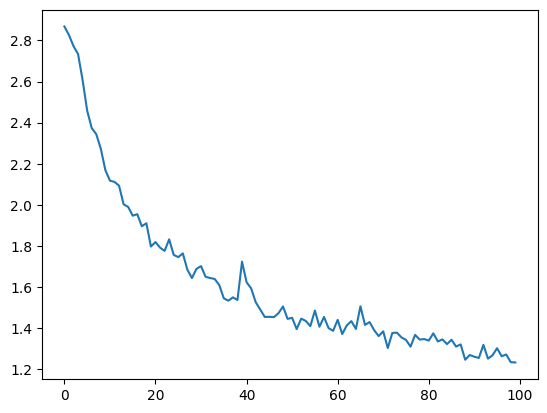

In [33]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)


def train(line_tensor,category_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    

    loss = criterion(output, category_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()


current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000

n_iters = 100000

for i in range(n_iters):
    category,line,category_tensor,line_tensor =random_training_example(category_lines, all_categories)
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss
    if(i+1) % plot_steps == 0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
    
    if(i+1) % print_steps == 0: 
        guess = category_from_output(output)
        correct = "✓" if guess == category else f"✗ ({category})"
        print(f"{i+1} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()


In [34]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [38]:
predict("Mitchell")


> Mitchell
Scottish
